## Introduction

Adrian Helmling-Cornell, University of Oregon

GWANW 2022

June 27, 2022

Welcome to the 2022 GWANW Tutorial session. This tutorial section covers the basics of LIGO data access and analysis. After finishing this session, you should be able to access publicly-available gravitational wave data, perform some basic manipulations to the data to find the gravitational wave signal, as well as some basic instrumental and data quality concerns to keep in mind when viewing LIGO data.

## Data Accesss

### GWOSC

The easiest way to access LIGO data as someone who isn't a collaboration member is through the [Gravitational Wave Open Science Center (GWOSC)](https://www.gw-openscience.org/workshops/). For each confidently-detected gravitational-wave event in LIGO & Virgo, GWOSC hosts over an hour of detector data from each observatory (f it was operating) as well as information about the confidence of the detection according to each searh pipeline that identified the event and the inferred parameters of the merger (more on that later).

### Example event: GW200224_222234

We will be mostly looking at GW200224_222234 in this session. GW_200224_222234 (or just GW200224 for short) was a gravitational wave (GW) candidate seen when all three observatories were operating. It was a merger of a $40.0^{+6.9}_{-4.5}$ solar masss black hole and a $32.5^{+5.0}_{-7.2}$ which produced a $68.6^{+6.6}_{-4.7}$ solar mass black hole. Approximately $7\times10^{47}$ Joules of energy were emitted as gravitational waves in the process. The data can be viewed and downloaded from the event's GWOSC page [here](https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200224_222234/v1).

For this tutorial I have downloaded 4096 seconds of data sampled at 4096 Hz from the Hanford and Livingston observatories from GW200224's event page. We can use the [GWpy](https://gwpy.github.io/) module for python to read and manipulate the data. We are at LIGO Hanford, so let's look at the Hanford data first.

First, a little bit of housekeeping.

In [1]:
!pip install -q 'gwpy'
!pip install -q 'matplotlib == 3.1.3'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from gwpy.timeseries import TimeSeries

In [3]:
H1_gwosc_data = TimeSeries.fetch_open_data('H1', 1266616124.4, 1266620220.4, verbose = True)  # TimeSeries.read('/content/drive/MyDrive/gwanw_22_tutorial/H-H1_GWOSC_4KHZ_R1-1266616125-4096.gwf', 'H1:GWOSC-4KHZ_R1_STRAIN') - alternate method to read in file from download, can be finnicky

Fetched 2 URLs from www.gw-openscience.org for [1266616124 .. 1266620221))
Reading data... [Done]
Reading data... [Done]


I chose to download a `.gwf` "GW frame" file for this tutorial. GWOSC also has data available Sin `.txt` and `.hdf5` formats. When you want to read in GW data with `GWpy`'s `TimeSeries.read()`, you must supply both the location of the data file as well as which channel you are interested in reading in. GWOSC channels should follow the pattern of [interferometer prefix]1:GWOSC-[sample rate]\_[revision_number]\_STRAIN.

Now let's plot the data and see what we downloaded!

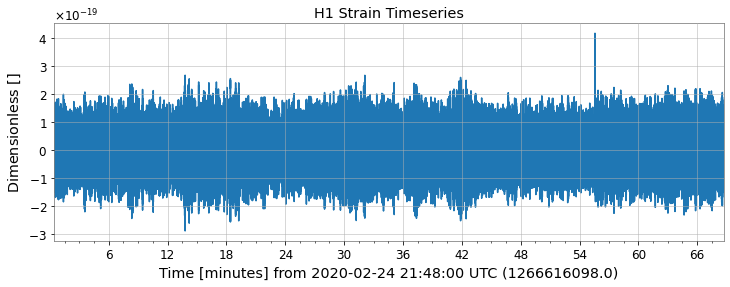

In [4]:
plot = H1_gwosc_data.plot(title = 'H1 Strain Timeseries')
plot.show()

What we've plotted is 4096 seconds of strain data centered on the event time of GW200224. Note that GW strain, $h=\frac{\Delta L}{L}$, is dimensionless. Since the detector's arms are 4000 m long, the fluctuations in the plot correspnd to an effectie arm cavity length change  on the order of $10^{-23}$ m.

### The TimeSeries

Let's take a moment to look at some of the properties of our `GWpy` timeseries.

In [5]:
print(H1_gwosc_data)

TimeSeries([-3.69406641e-20, -7.29910911e-20, -8.67067489e-20,
            ...,  5.45119288e-21,  5.03914324e-20,
             8.76634248e-20]
           unit: dimensionless,
           t0: 1266616124.3999023 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


A timeseries is composed of more than just a list of numbers corresponding to the data. While that is one part of it, you can see that the time of the first sample and the time separation between samples is included too. Note that these are endowed with `astropy` units so we cannot directly do math with something like

In [6]:
print(H1_gwosc_data.dt, type(H1_gwosc_data.dt))

0.000244140625 s <class 'astropy.units.quantity.Quantity'>


we must ask for the unit-free version of what we're interested in, like so:

In [7]:
print(H1_gwosc_data.dt.value, type(H1_gwosc_data.dt.value))

0.000244140625 <class 'numpy.float64'>


Also associated with this `TimeSeries` is the list of times associated with each data point. This can be examined by

In [8]:
print(H1_gwosc_data.times, '\n', H1_gwosc_data.times.value)

[1.26661612e+09 1.26661612e+09 1.26661612e+09 ... 1.26662022e+09
 1.26662022e+09 1.26662022e+09] s 
 [1.26661612e+09 1.26661612e+09 1.26661612e+09 ... 1.26662022e+09
 1.26662022e+09 1.26662022e+09]


Again, note the presence of units in the first printed line.

### Finding the GW

From GWOSC, we know that the GW was detected at February 24, 2020 at 22:22:34.4 UTC (ccordinated universal time). This is the time at $0^{\circ}$ longitude (i.e. London, U.K.) without considering daylight saving time. However, detector data uses the GPS time standard - a time of $0$ corresponds to 00:00:00 UTC on January 6th 1980. GWOSC has a page where you can convert between time standards, but this can also been done by `GWpy`. Let's see what GPS time the event time corresponds to.

In [9]:
from gwpy.time import tconvert
event_time = 'February 24, 2020 22:22:34.4'
event_time = tconvert(event_time)
print(event_time)

1266618172.4


Let's explicitly call `matplotlib` so that we can mark the event time with a dashed line.

In [10]:
import matplotlib.pyplot as plt
#%matplotlib inline - Jupyter magic

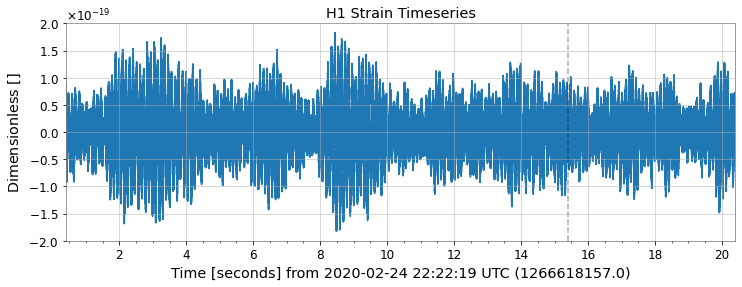

In [11]:
plot = H1_gwosc_data.plot(title = 'H1 Strain Timeseries', xlim = (event_time - 15, event_time + 5), ylim = (-2e-19, 2e-19))
plt.axvline(event_time, c = 'k', ls = '--', alpha = .33)
plt.show()

There doesn't seem to be anything special about the purported merger time - we have to do some signal processing to find the GW. First let's restrict the data to just what's shown here using the `times` array associated with the data.

In [12]:
H1_data_short = H1_gwosc_data[(H1_gwosc_data.times.value > event_time - 15) & (H1_gwosc_data.times.value < event_time + 5)]

### Signal Processing

To justify the transformations we have to make to the data, we must make a brief foray into signal processing. Recall that we can decompose any function of time, like our $h(t)$ into a combination of sine waves with certain frequencies and amplitudes. Let's see what the frequency content of our data looks like.

In [13]:
H1_fft = TimeSeries.fft(H1_data_short)

The Fourier transform of our time-domain signal is a new kind of `GWpy` object caled a `FrequencySeries`. Just like a `TimeSeries` it comes with additional information.

In [14]:
print(H1_fft)

FrequencySeries([-9.87011592e-24+0.00000000e+00j,
                 -1.97404238e-23+1.10209882e-25j,
                 -1.97419554e-23+2.20547083e-25j, ...,
                  2.48769051e-25-2.73854556e-26j,
                  2.42335953e-25+1.32825139e-26j,
                  2.97036729e-25+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.05 Hz,
                epoch: 1266618157.400146,
                name: Strain,
                channel: None)


In [15]:
print(H1_fft.frequencies)

[0.00000e+00 5.00000e-02 1.00000e-01 ... 2.04790e+03 2.04795e+03
 2.04800e+03] Hz


We can now plot the Fourier amplitude at each frequency.

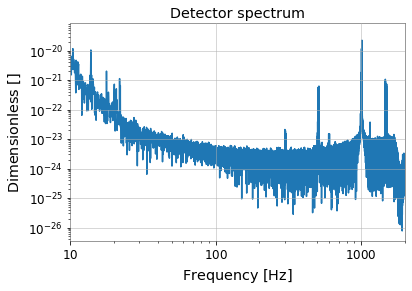

In [16]:
plot = H1_fft.abs().plot(xlim = (10, 2000), xscale = 'log', yscale = 'log', title = 'Detector spectrum')

A semi-log plot is useful for highlighting lines in the data.

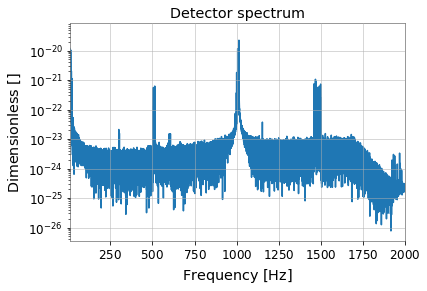

In [17]:
plot = H1_fft.abs().plot(xlim = (10, 2000), xscale = 'linear', yscale = 'log', title = 'Detector spectrum')

At low frequencies the signal in LIGO is dominated by seismic noise. Any low-frequency content in the data is filtered out before it's released to GWOSC. Our sampling rate of 4096 Hz sets the upper limit on the frequency content of our data via Nyquist\'s theorem. The large spikes in amplitude are from certain noise sources in the instrument or calibration tools.

Notice that the noise is \"colored\", that is, the amplitude isn't even across all frequencies. We need to \"whiten\" the data so that any transient changes in amplitude at a certain frequency are more obvious.

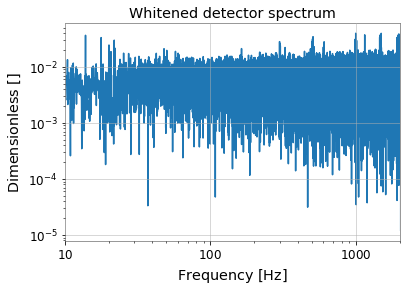

In [18]:
H1_data_whitened = H1_data_short.whiten()
whitened_fft = TimeSeries.fft(H1_data_whitened)
plot = whitened_fft.abs().plot(xlim = (10, 2000), xscale = 'log', yscale = 'log', title = 'Whitened detector spectrum')

The time-domain effect of whitening the signal is

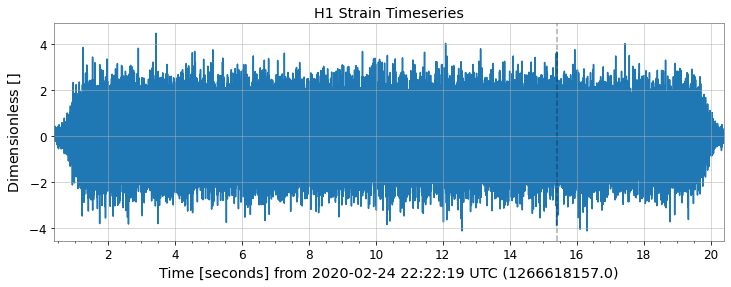

In [19]:
plot = H1_data_whitened.plot(title = 'H1 Strain Timeseries')
plt.axvline(event_time, c = 'k', ls = '--', alpha = .33)
plt.show()

Now we could argue that there's a spike in the strain timeseries that coincides with the event time. However, the amplitude of the spike is comperable to that of other nearby fluctuations, so this isn\'t a conclusive argument for the existence of a GW in our data. LIGO was designed to be most sensitive in the band of tens of Hz to a few hundred Hz. This allows us to see the ends of inspirals from solar mass- and tens of solar mass-scale collisions frequently. Let's focus on those frequencies by bandpassing the signal. We will only keep data between 30 and 500 Hz.

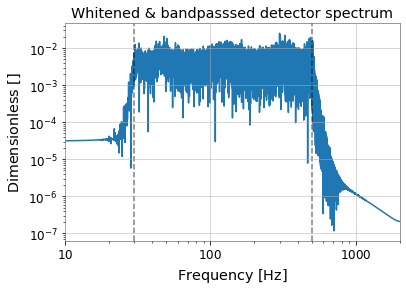

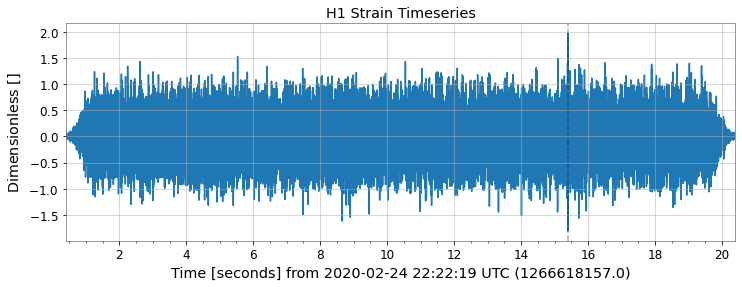

In [20]:
bandpassed = H1_data_whitened.bandpass(30, 500)
bandpassed_fft = TimeSeries.fft(bandpassed)
plot = bandpassed_fft.abs().plot(xlim = (10, 2000), xscale = 'log', yscale = 'log', title = 'Whitened & bandpasssed detector spectrum')
plt.axvline(30, c = 'k', ls = '--', alpha = .5)
plt.axvline(500, c = 'k', ls = '--', alpha = .5)
plt.show()
plot = bandpassed.plot(title = 'H1 Strain Timeseries')
plt.axvline(event_time, c = 'k', ls = '--', alpha = .33)
plt.show()

Now there finally could be something in our data! Let's zoom in.

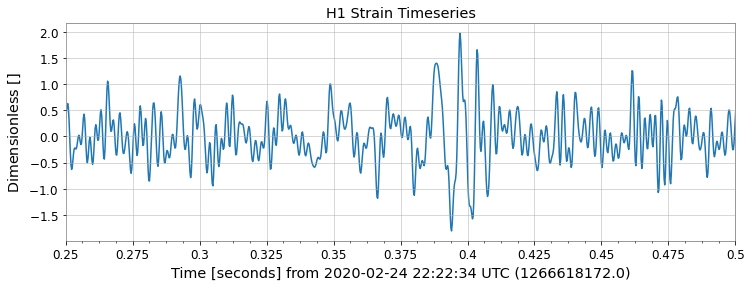

In [21]:
plot = bandpassed.plot(title = 'H1 Strain Timeseries', xlim = (event_time - .15, event_time + .1))
plt.show()

That looks like a signature of a GW! We can repeat the process with Livingston data. Since the response of both detectors is similar, we should expect to see a similar pattern in the strain timeseries of Livingston contemporaneous with the Hanford data. Note that due to the relative orientation of the two detectors\' arms, we must multiply one dataset by $-1$ to directly compare the two.

In [22]:
L1_gwosc_data = TimeSeries.fetch_open_data('L1', 1266616124.4, 1266620220.4, verbose = True)  # TimeSeries.read('/home/adrian.helmling-cornell/public_html/2022_gwanw/L-L1_GWOSC_4KHZ_R1-1266616125-4096.gwf', 'L1:GWOSC-4KHZ_R1_STRAIN')
L1_gwosc_data_filtered = L1_gwosc_data[(L1_gwosc_data.times.value > event_time - 15) & (L1_gwosc_data.times.value < event_time + 5)]
L1_gwosc_data_filtered = L1_gwosc_data_filtered.whiten()
L1_gwosc_data_filtered = L1_gwosc_data_filtered.bandpass(30, 500)
L1_gwosc_data_filtered *= -1

Fetched 2 URLs from www.gw-openscience.org for [1266616124 .. 1266620221))
Reading data... [Done]
Reading data... [Done]


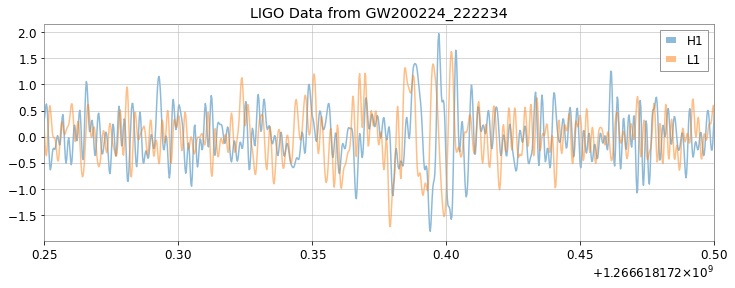

In [23]:
plt.figure(figsize = (12, 4))
ax = plt.gca()
ax.plot(bandpassed, label = 'H1', alpha = .5)
ax.plot(L1_gwosc_data_filtered, label = 'L1', alpha = .5)
ax.set_xlim(float(event_time) - .15, float(event_time) + .1)
plt.legend()
plt.title('LIGO Data from GW200224_222234')
plt.show()

There's still some disagreement - that's because the LIGO sites aren't on top of one another. There is some lag between when the wave reaches the Livingston detector and the wave reaching the Hanford detector. We can make the peaks line up by shifting the Livingston tmeseries by a few milliseconds.

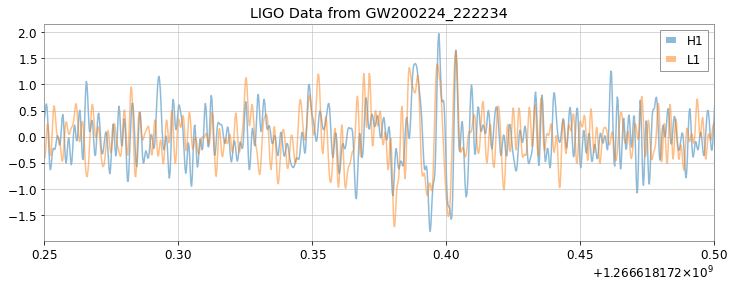

In [24]:
L1_gwosc_data_filtered.shift('1.6ms')
plt.figure(figsize = (12, 4))
ax = plt.gca()
ax.plot(bandpassed, label = 'H1', alpha = .5)
ax.plot(L1_gwosc_data_filtered, label = 'L1', alpha = .5)
ax.set_xlim(float(event_time) - .15, float(event_time) + .1)
plt.legend()
plt.title('LIGO Data from GW200224_222234')
plt.show()

The only signals that seem to overlap coincide with the GW event time. We have successfully uncovered the GW in our data!

## Data Quality Concerns

Because the LIGO detectors are so sensitive, there are may ways that changes in the local environment can impact the detectors. Next we will briefly discuss how to learn about these effects in public data.

### Noise

The detectors are subject to a number of noise sources from environmnetal effects coupling to different parts of the instrument. One quick way to get a handle on the state of the dector around an event time is the amplitude spectral density (ASD). The ASD is (glossing some important details) an average spectrum over a period of time. By looking at the ASD for the h(t) channel, we can get a sense of what noise sources were affecting the detector.

This is handled by making a new `GWpy` `FrequencySeries`.

In [25]:
H1_asd = H1_gwosc_data.asd(fftlength = 10)

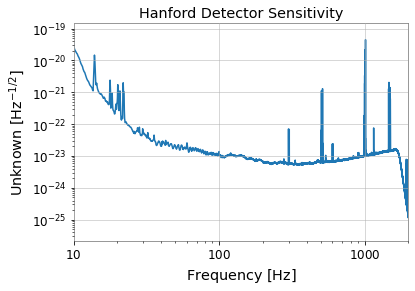

In [26]:
plot = H1_asd.plot(xlim = (10, 2000), title = 'Hanford Detector Sensitivity')

We can immediately compare Hanford\'s sensitivity in the 4096 seconds around GW200224 to Livingston\'s sensitivity curve.

In [27]:
L1_asd = L1_gwosc_data.asd(10)

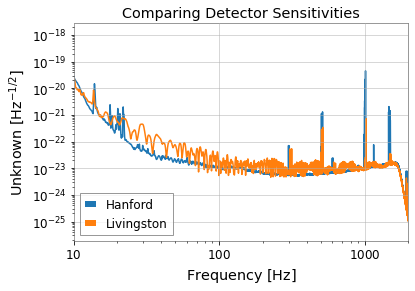

In [28]:
plot = H1_asd.plot(label = 'Hanford')
ax = plot.gca()
ax.plot(L1_asd, label = 'Livingston')
ax.set_xlim(10, 2000)
ax.set_title('Comparing Detector Sensitivities')
ax.legend(loc = 'lower left')
plot.show()

We can immediately see that at low frequencies, Livingston is less noisy. The forest of lines around 20 Hz are ASC dither lines and calibration line nonlinearities. Lists of line locations for each interferometer in O3 can be found [on GWOSC](https://www.gw-openscience.org/O3/o3speclines/). We can also see that the violin mode harmonics are higher at Hanford. This is an indication of high winds during or preceding the data. We can compare ASDs across different epochs to see how detector sensitivity has changed. Below is 4096 seconds of data from around LIGO\'s first recorded event, GW150914.

In [29]:
O1_H1_gwosc_data = TimeSeries.fetch_open_data('H1', 1126257414.4, 1126261510.4)  # TimeSeries.read('/home/adrian.helmling-cornell/public_html/2022_gwanw/H-H1_GWOSC_4KHZ_R1-1126257415-4096.gwf', 'H1:GWOSC-4KHZ_R1_STRAIN')

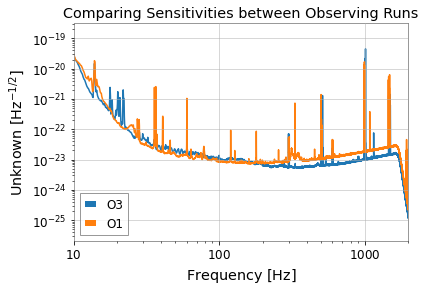

In [30]:
plot = H1_asd.plot(label = 'O3')
ax = plot.gca()
ax.plot(O1_H1_gwosc_data.asd(10), label = 'O1')
ax.set_xlim(10, 2000)
ax.set_title('Comparing Sensitivities between Observing Runs')
ax.legend(loc = 'lower left')
plot.show()

## Glitches

The final class of data quality concerns we will touch on is glitching. Glitches are short-duration transients with manifold causes and morphologies. The most infamous glitch is the the one that occurred during the inspiral of GW170817, the first binary neutron star merger LIGO observed. Here is an image of the glitch taken from [this paper.](https://ui.adsabs.harvard.edu/abs/2018PhRvD..98h4016P/abstract) ![glitch](bns_l1_glitch.png "GW170817 Glitch")

To see whether there is glitching that could impact the event, we can make a spectrogram with `Gwpy`. A spectrogram records the peaks and troughs of a spectrum as a function of time.

In [31]:
H1_spectrogram = bandpassed.crop(event_time - 3, event_time + .25).spectrogram2(fftlength = 1 / 32, overlap = 1 / 33) ** (1 / 2)
H1_spectrogram = H1_spectrogram.crop_frequencies(30, 500)

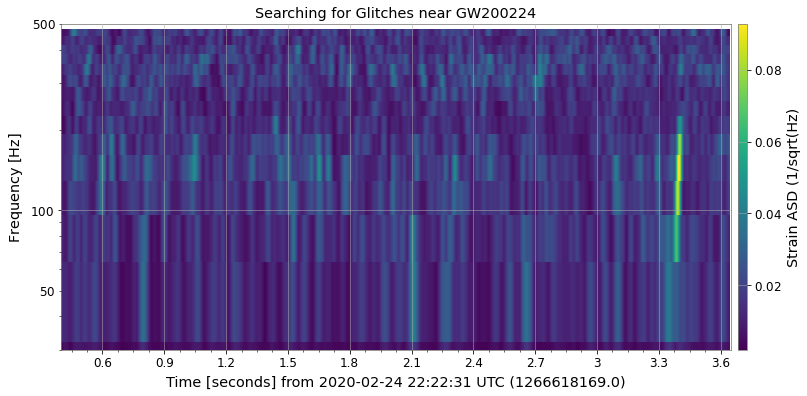

In [32]:
plot = H1_spectrogram.plot(ylim = (30, 500), yscale = 'log', title = 'Searching for Glitches near GW200224')
ax = plot.gca()
ax.colorbar(label = 'Strain ASD (1/sqrt(Hz)')
plot.show()

The data shows no signs of glitches during the time-freuency window of the inspiral track. This is a pretty clean event candidate - it will be straightforward to perform parameter estimation on.

I hope those of you learned a little bit about how to access and assess GW candidate data. Please don\'t hesitate to reach out to me if you have any questions. You can email me at ahelmlin AT uoregon.edu.